# EC Processing Functions
This notebook contains some work on figuring out implementations of common EC Processing functions. It's meant as a temporary workspace/testbed

In [1]:
import sys
from pathlib import Path

from datetime import datetime
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import stats
from scipy import optimize
from scipy import signal
from statsmodels.tsa.stattools import acf

sys.path.append('../python')
from tilt_corrections.double_rotation_methods import *
from tilt_corrections.planar_fit_methods import *
from utils import *

In [2]:
# directories specific to Alex's computer
data_dir = Path('/Users/waldinian/Project_Data/Platinum_EC/BB-SF')
EC_4m_dir = data_dir / 'EC' / '4m' / 'Converted'
EC_7m_dir = data_dir /'EC' / '7m' / 'Converted'
Snow_dir = data_dir / 'Snow'
SoilHF_dir = data_dir / 'SoilHF'

Our data is split up into a bunch of files. Here, I'm just looping through them.

Load some summary information on our data files into a dataframe indexed by file timestamp

Compute some summary data to add to the dataframe

In [3]:
# record file timestamps and paths
EC_7m_fast_fns = list(EC_7m_dir.glob('TOA5*10Hz*dat'))
EC_7m_df = pd.DataFrame(dict(fn=EC_7m_fast_fns))
EC_7m_df['TIMESTAMP'] = list(map(get_timestamp_from_fn, EC_7m_df['fn']))
EC_7m_df = EC_7m_df.sort_values('TIMESTAMP').set_index('TIMESTAMP')
EC_7m_df.head()

# compute summary statistics by looping through data files
renaming_dict=dict(
    Ux_CSAT3B='U',
    Uy_CSAT3B='V',
    Uz_CSAT3B='W',
    Ts_CSAT3B='Ts',
    rho_c_LI7500='rhoCO2',
    rho_v_LI7500='rhoH2O',
    P_LI7500='P'
)
summary_data = pd.concat([compute_summary(fn, renaming_dict) for fn in tqdm(EC_7m_df['fn'])])
summary_data = summary_data.set_index(EC_7m_df.index)
EC_7m_df = EC_7m_df.merge(summary_data, left_index=True, right_index=True)

  7%|███▋                                                | 48/671 [00:02<00:27, 22.44it/s]

KeyboardInterrupt: 

  7%|███▋                                                | 48/671 [00:20<00:27, 22.44it/s]

# Tilt Corrections
## Double rotation method (Wilczak et al, 2001)
Align $\hat i$ with the mean windspeed for each block. Do this by first rotating in azimuth ($\theta$) then in elevation ($\phi$). This method does not attempt to learn anything about the surrounding topography/streamline landscape, and instead naively aligns its coordinate system with the current windspeed.

## Planar fit method (Wilczak et al, 2001)
Align $\hat i$ for each block with the mean windspeed over all blocks. Then for each block, rotate in azimuth ($\theta$) to align the mean windspeed with $\hat i$ in the $uv$-plane. This approximates the surrounding topography/streamlines as an infinite plane with some orientation, and tries to match the instrument coordinates to the orientation of that plane.

## Continuous planar fit method (Ross et al 2015)
Perfrom the DR method using a fourier series approximation for $\phi \sim \mathcal F (\theta)$ of order $N$, computed across all blocks. When $N$ is maximized, this is analagous to the DR method. When $N=1$, this is analagous to the standard planar fit method. This method assumes approximates the surrounding topography/streamlines with a smooth periodic function, and tries to match the instrument coordinates to reflect that (with some predetermined resolution). This is nice because it doesn't suffer from underfitting like the Planar Fit method, but remains infinitely differentiable making it nice for further analysis.

In [10]:
EC_7m_df_rot = EC_7m_df.copy()

Demonstration of various tilt correction algorithms

In [11]:
# generate some continuous data to plot against
theta_sim = np.linspace(0, 2*np.pi, 1001)

# compute angles using the double-rotation algorithm
theta, phi_DRF = get_double_rotation_angles(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'])

# we'll loop through 100 iterations of each fit using a different set of training data each time
# to get some sense of uncertainty
n = 500
phi_sim_2CPF = np.empty((theta_sim.size, n))
phi_sim_15CPF = np.empty((theta_sim.size, n))
phi_sim_SPF = np.empty((theta_sim.size, n))
train_n = int(theta.size*0.7)
for i in tqdm(range(n)):
    # get some random theta angles to train on
    idx = np.random.choice(np.arange(theta.size), size=train_n, replace=False)
    # 4th order continuous planar fit
    phi_approx_15CPF, _ = get_continuous_planar_fit_angles(theta[idx], phi_DRF[idx], 4)
    phi_sim_15CPF[:, i] = phi_approx_15CPF(theta_sim)
    # 2nd order continuous planar fit
    phi_approx_2CPF, _ = get_continuous_planar_fit_angles(theta[idx], phi_DRF[idx], 2)
    phi_sim_2CPF[:, i] = phi_approx_2CPF(theta_sim)
    # 1st order continuous planar fit
    phi_approx_SPF, _ = get_continuous_planar_fit_angles(theta[idx], phi_DRF[idx], 1)
    phi_sim_SPF[:, i] = phi_approx_SPF(theta_sim)
    
# convert rad->deg
theta_sim = theta_sim
theta = theta
phi_DRF = phi_DRF*180/np.pi
phi_sim_15CPF = phi_sim_15CPF*180/np.pi
phi_sim_2CPF = phi_sim_2CPF*180/np.pi
phi_sim_SPF = phi_sim_SPF*180/np.pi

100%|███████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.74it/s]


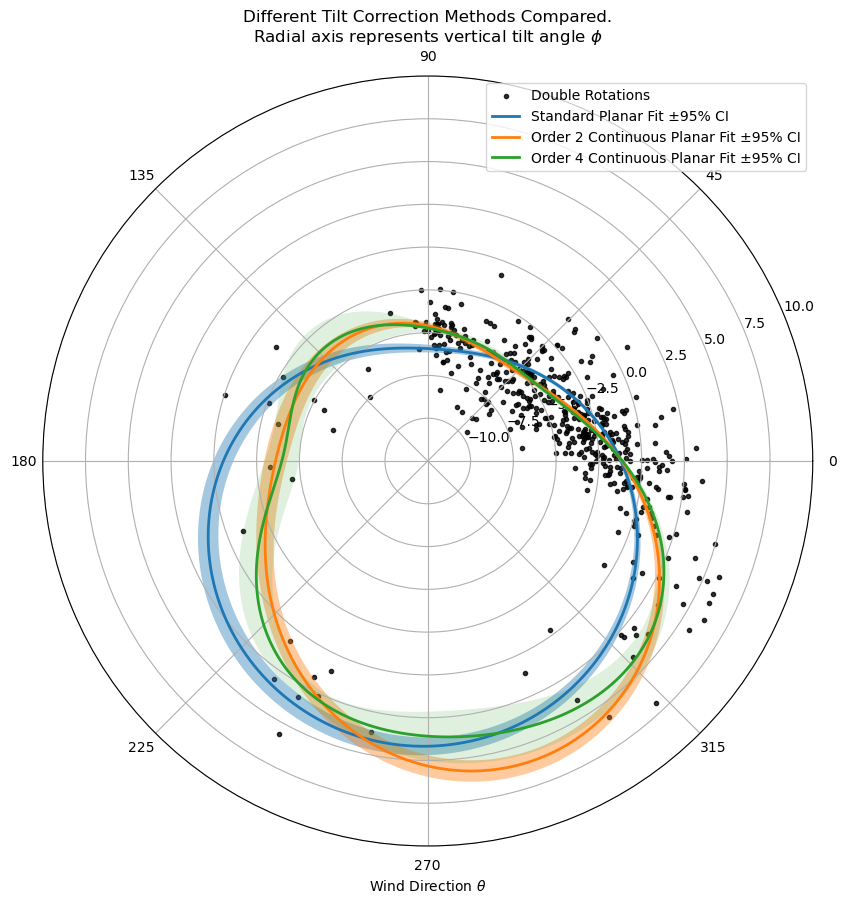

In [12]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(projection= 'polar')
plt.scatter(theta[idx], phi_DRF[idx], s=3**2, c='k', label='Double Rotations', alpha=0.8)
plt.plot(theta_sim, phi_sim_SPF.mean(1), label='Standard Planar Fit ±95% CI', lw=2)
plt.fill_between(theta_sim, phi_sim_SPF.mean(1) - phi_sim_SPF.std(1)*1.96, phi_sim_SPF.mean(1) + phi_sim_SPF.std(1)*1.96, alpha=0.4)
plt.plot(theta_sim, phi_sim_2CPF.mean(1), label='Order 2 Continuous Planar Fit ±95% CI', lw=2)
plt.fill_between(theta_sim, phi_sim_2CPF.mean(1) - phi_sim_2CPF.std(1)*1.96, phi_sim_2CPF.mean(1) + phi_sim_2CPF.std(1)*1.96, alpha=0.4)
plt.plot(theta_sim, phi_sim_15CPF.mean(1), label='Order 4 Continuous Planar Fit ±95% CI', lw=2)
plt.fill_between(theta_sim, phi_sim_15CPF.mean(1) - phi_sim_15CPF.std(1)*1.96, phi_sim_15CPF.mean(1) + phi_sim_15CPF.std(1)*1.96, alpha=0.15)

plt.xticks(np.arange(0, 2*np.pi, np.pi/4), np.arange(0, 360, 45))
plt.ylim(-12.5, 10)
plt.xlabel('Wind Direction $\\theta$')
plt.ylabel('')
# plt.ylim(phi_DRF.min() - 5, phi_DRF.max() + 5)
plt.title('Different Tilt Correction Methods Compared.\nRadial axis represents vertical tilt angle $\\phi$')
plt.legend();

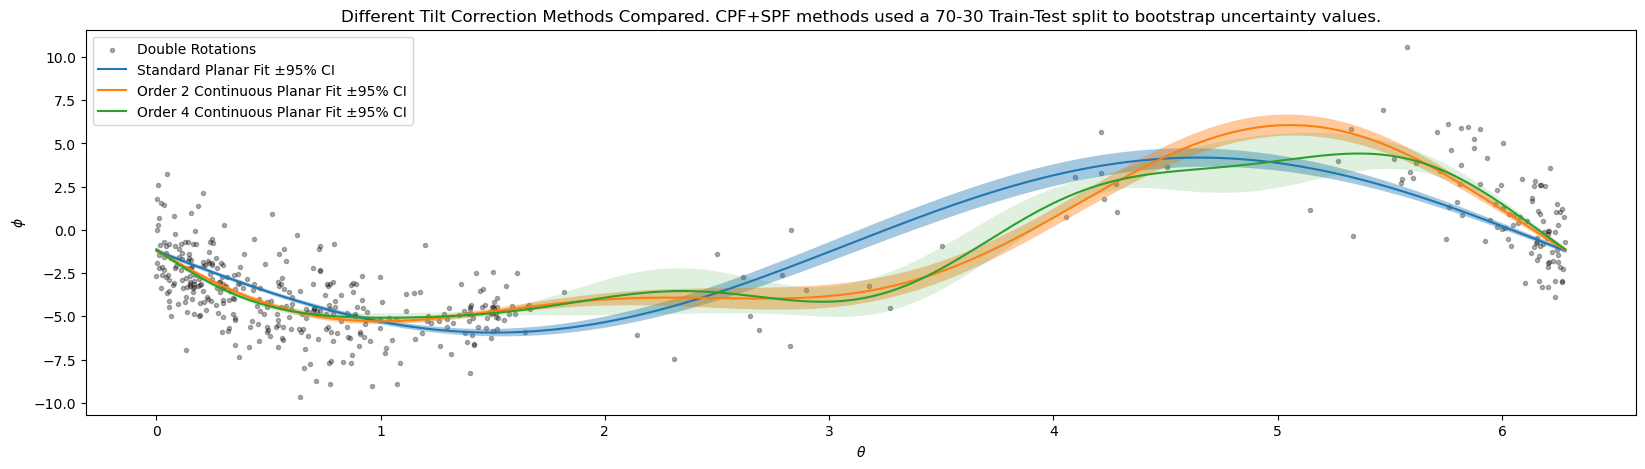

In [13]:
fig = plt.figure(figsize=(20,5))
plt.scatter(theta[idx], phi_DRF[idx], s=3**2, c='k', label='Double Rotations', alpha=0.3)
plt.plot(theta_sim, phi_sim_SPF.mean(1), label='Standard Planar Fit ±95% CI')
plt.fill_between(theta_sim, phi_sim_SPF.mean(1) - phi_sim_SPF.std(1)*1.96, phi_sim_SPF.mean(1) + phi_sim_SPF.std(1)*1.96, alpha=0.4)
plt.plot(theta_sim, phi_sim_2CPF.mean(1), label='Order 2 Continuous Planar Fit ±95% CI')
plt.fill_between(theta_sim, phi_sim_2CPF.mean(1) - phi_sim_2CPF.std(1)*1.96, phi_sim_2CPF.mean(1) + phi_sim_2CPF.std(1)*1.96, alpha=0.4)
plt.plot(theta_sim, phi_sim_15CPF.mean(1), label='Order 4 Continuous Planar Fit ±95% CI')
plt.fill_between(theta_sim, phi_sim_15CPF.mean(1) - phi_sim_15CPF.std(1)*1.96, phi_sim_15CPF.mean(1) + phi_sim_15CPF.std(1)*1.96, alpha=0.15)

plt.xlabel('$\\theta$')
plt.ylabel('$\\phi$')
# plt.ylim(phi_DRF.min() - 5, phi_DRF.max() + 5)
plt.title('Different Tilt Correction Methods Compared. CPF+SPF methods used a 70-30 Train-Test split to bootstrap uncertainty values.')
plt.legend();

In [14]:
EC_7m_df_rot[['U_mean_CPF', 'V_mean_CPF', 'W_mean_CPF']] = continuous_planar_fit_from_uvw(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'], 2)
EC_7m_df_rot[['U_mean_SPF', 'V_mean_SPF', 'W_mean_SPF']] = continuous_planar_fit_from_uvw(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'], 1)
EC_7m_df_rot[['U_mean_DRF', 'V_mean_DRF', 'W_mean_DRF']] = double_rotation_fit_from_uvw(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'])

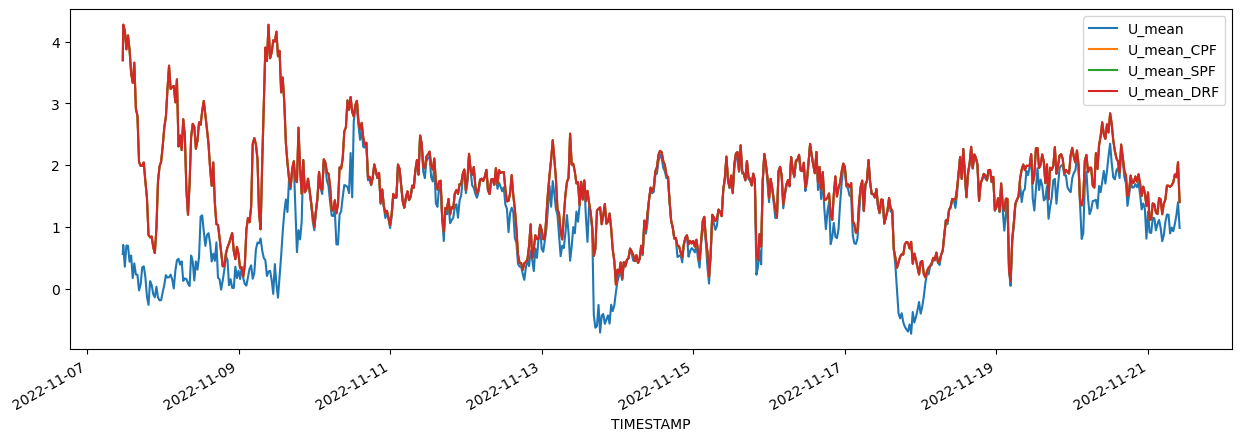

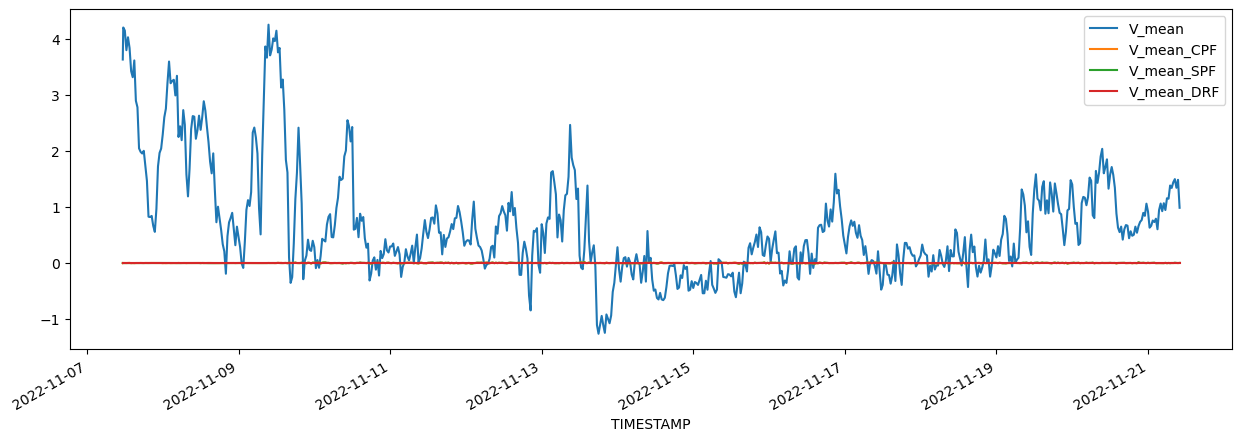

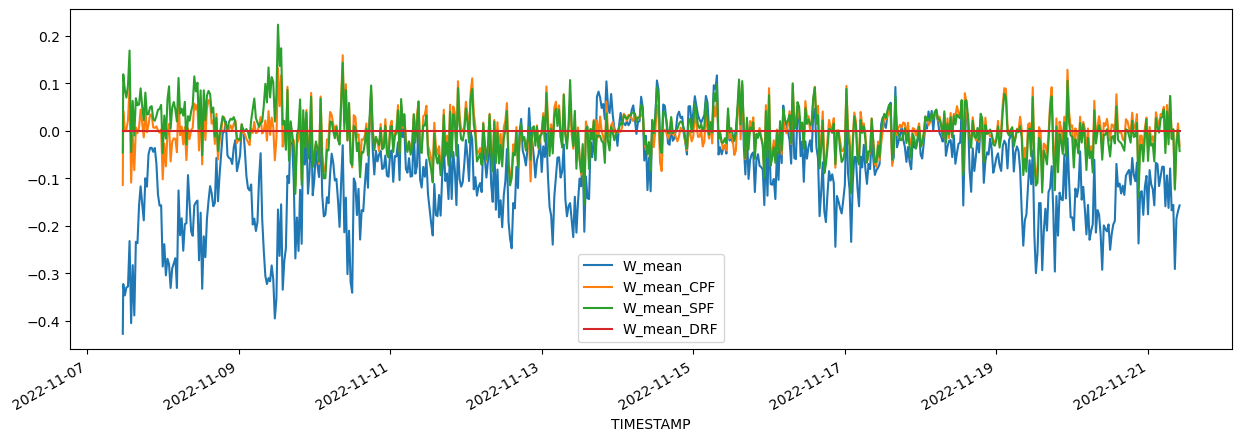

In [13]:
EC_7m_df_rot[['U_mean', 'U_mean_CPF', 'U_mean_SPF', 'U_mean_DRF']].plot(figsize=(15,5))
EC_7m_df_rot[['V_mean', 'V_mean_CPF', 'V_mean_SPF', 'V_mean_DRF']].plot(figsize=(15,5))
EC_7m_df_rot[['W_mean', 'W_mean_CPF', 'W_mean_SPF', 'W_mean_DRF']].plot(figsize=(15,5));


# Data Cleaning (Vitale et al 2020)
Currently a work in progress
## Instrumental Issues

In [302]:
'''section 2.2.1 of Vitale et al, 2020'''
# from tilt_corrections import get_double_rotation_angles
# import numpy as np
# import pandas as pd
# from scipy import signal

def li_7500_flags(flag):
    # "core" flag is raised
    if flag < 0b11110000:
        return 2
    # AGC < 40%
    elif flag < 0b11110110:
        return 1
    # no concerns
    return 0

def csat3_flags(flag):
    # "core" flag is raised
    if (flag >> 12) < 0b1111:
        return 2
    # no concerns
    return 0

def csat3b_flags(flag):
    # "core" flag is raised
    if flag:
        return 2
    return 0

def irgason_flags(flag):
    if flag:
        return 2
    return 0

flag_detector = {
    'LI-7500': li_7500_flags,
    'CSAT3': csat3_flags,
    'CSAT3B': csat3b_flags,
    'IRGASON-IRGA': irgason_flags,
    'IRGASON-Sonic': irgason_flags
}

def flag_diagnostics(df, column_map):
    '''detects instrument diagnostic flags
    
    Supported instrument names:
    - LI-7500
    - CSAT3
    - CSAT3B
    

    Parameters
    ----------
    df : pd.DataFrame
    column_map : dict
        mapping from diagnostic_column_name --> instrument model

    Returns
    -------
    flags : np.array
        1d array containing severe (2)/moderate (1)/mild quality flags (0)'''
    
    all_flags = np.array([
        list(map(flag_detector[instr_model], df[col])) 
        for col, instr_model in column_map.items()
    ])
    
    # take the worst flag for each timestamp
    flags = all_flags.max(axis=0)
    
    return flags

def flag_wind_direction(U, V, W, instrument_name):
    '''detects problem wind directions inherent to an instrument
    
    Note that U, V, W must be local anemometer coordinates, ie no previous rotations can have been done. This includes north-alignment.
    
    Supported instrument names:
    - CSAT3
    - CSAT3B
    - IRGASON
    
    U, V, W : 1d arrays
        wind components in local anemometer coordinates
    instrument_name: str
        name of the instrument'''
    
    # get angle of attack information, convert to degrees
    theta, _ = get_double_rotation_angles(U, V, W)
    theta = theta*180/np.pi # theta ranges from 0 to 360
    flags = np.zeros(theta.shape[0])
    
    if instrument_name in ['CSAT3', 'CSAT3B']:
        flags[(theta > 170) & (theta < 190)] = 2
        
    return flags
        
def flag_all(df, column_map, U, V, W, instrument_name):
    flags = np.empty((df.shape[0], 2))
    flags[:, 0] = flag_diagnostics(df, column_map)
    flags[:, 1] = flag_wind_direction(U, V, W, instrument_name)
    flags = flags.max(axis = 1)
    return flags

def flag_spikes(L, df):
    '''spike detection, Vicker and Mahrt 1997
    Need to implement spike run filtering'''
    
    df = df.copy()
    
    spikes = np.zeros(df.shape[0])
    # pd.DataFrame.rolling()
    # rolling_mean = signal.fftconvolve(data, np.ones((L, data.shape[1]))/L, axes=0, mode='valid')
    std35 = df.rolling(window=L).std()*3.5
    mean = df.rolling(window=L).mean()
    
    upper = mean + std35
    lower = mean - std35
    df.loc[(df < lower).max(1)] = np.nan
    df.loc[(df > upper).max(1)] = np.nan
    
    df = df.interpolate()
    
    return lower, upper, flags

In [324]:
test_file = read_campbell_file(EC_7m_df.iloc[368, 0])
flag_diagnostics(test_file, dict(DIAG_LI7500='LI-7500'))
flag_wind_direction(test_file['Ux_CSAT3B'], test_file['Uy_CSAT3B'], test_file['Uz_CSAT3B'], 'CSAT3B').sum()

test_file2 = flag_spikes(500, test_file[['rho_c_LI7500']])
# plt.plot(flag_all(test_file, dict(DIAG_LI7500='LI-7500'), test_file['Ux_CSAT3B'], test_file['Uy_CSAT3B'], test_file['Uz_CSAT3B'], 'CSAT3B')  )

(10500.0, 10800.0)

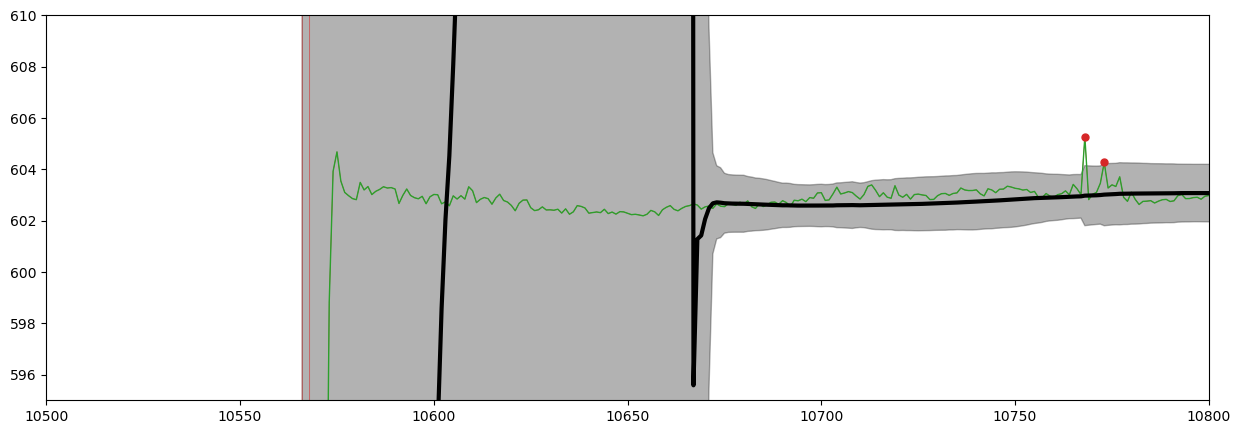

In [325]:
plt.figure(figsize=(15,5))
plt.fill_between(upper.index, lower.rho_c_LI7500, upper.rho_c_LI7500, alpha=0.3, color='k')
plt.plot(test_file.index, test_file.rho_c_LI7500, lw=0.4, color='C3')
plt.plot(test_file2.index, test_file2.rho_c_LI7500, lw=1, color='C2')
plt.plot(upper.index, (lower.rho_c_LI7500 + upper.rho_c_LI7500)/2, lw=3, color='k')
plt.plot(test_file.iloc[flags > 0].index, test_file.iloc[flags > 0].rho_c_LI7500, 'o', markersize=5, color='C3')


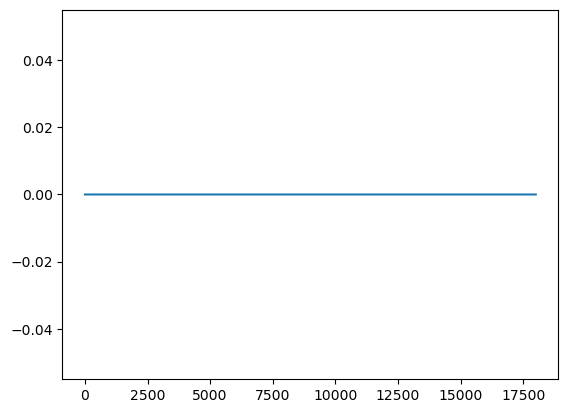

In [112]:
plt.plot(flag_wind_direction(test_file['Ux_CSAT3B'], test_file['Uy_CSAT3B'], test_file['Uz_CSAT3B'], 'CSAT3B'))